<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Módulo 13: Almacenes de datos: Datalakes</font></h2>



<h1><font color="#00586D" size=5>Capstone XIII - Orquestación de ETLs en un Datalake</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Javier Cózar</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

## NobelPrice

En este capstone vamos a trabajar con los datos de las celebraciones de premios Nobel y las personas y entidades laureadas. Para ello haremos uso de la API de [nobelprize.org](https://www.nobelprize.org/about/developer-zone-2/). Esta API tiene documentación en formato OpenAPI alojado en la plataforma [swaggerhub](https://app.swaggerhub.com/apis/NobelMedia/NobelMasterData/2.1), que es un estandar bastante extendido y como podréis comprobar es muy cómodo e interesante de explorar!

Vamos a crear un datalake usando **AWS S3**, a implementar nuestras ETLs en **AWS Lambda**, y a orquestar su ejecución a través de **Prefect**, ejecutando el flujo localmente. A continuación describimos qué ETLs implementar y los pasos a seguir para orquestar las ETLs con Prefect.


### Descripción

Los premios Nobel se celebran anualmente (salvo algún problema, como ocurrió durante _la segunda guerra mundial_). Vamos a automatizar la extracción de los datos todos los **1 de enero de cada año** haciendo lo siguiente:
- Descargaremos los datos **del año anterior para todas las categorías** (`che`, `eco`, `lit`, `pea`, `phy`, `med`)
- Almacenaremos en el datalake (prefijo `raw`) estos datos en formato parquet
- Ejecutaremos las ETL implementadas (bronze y silver)

Finalmente, usaremos la libreta de jupyter para acceder a las tablas generadas por la ETL y **responder ciertas preguntas de analítica**.

## Ejercicio 1. Crear el bucket de S3 que será nuestro datalake

Vamos a crear un bucket de S3 en nuestra cuenta de AWS Academy. Este bucket contendrá los prefijos:

- **raw**: contendrá los datos en crudo extraídos de la API.
- **bronze**: contendrá tablas que serán uniones de tablas con nombres de columnas posiblemente modificadas y tipos de columnas casteadas.
- **silver**: contendrá tablas de alto nivel que serán utilizadas para acceder a la información granularmente.

## Ejercicio 2. Crear la layer para AWS Lambda

Vamos a utilizar `pandas`, `pyarrow`, `requests` y `s3fs` en todas nuestras lambdas. La consola tiene un límite de 50MB por zip, pero nuestra layer es mayor. Para poder crearla hay que subir el zip `layer.zip` a un bucket de S3 y crear la layer a partir de la S3 URI. La layer está creada para `python 3.8` y arquitectura `x86_64`.

**NOTA**: podéis ver las versiones de los paquetes utilizados en las layers para lambda en el fichero `requirements_lambda.txt`. Hay que usar la misma versión de python y de los paquetes para desarrollar en local y así evitar errores (podéis probar el código dentro de una imagen de docker si fuese necesario).

## Ejercicio 3. Crear las AWS Lambdas de extracción

Las funciones deben extraer información de `nobelPrizes` y `laureates`, es decir, premios Nobel y laureados o personas premiadas. Para ello:

1. Usar el endpoint `http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}` para obtener la información de todos los premios Nobel para una categoría y un año concreto.
2. Usar el endpoint `http://api.nobelprize.org/2.1/laureate/{laureateID}` para obtener la información de un laureado en base a su ID.

Los datos serán almacenados en el datalake en formato parquet, que permite leer cómodamente varios ficheros con una llamada `pd.read_parquet` y podríamos ejecutar procesos de compactación de datos cuando fuese necesario. Sin embargo, hay ciertas estructuras complejas que parquet no tiene implementado en su versión en python (algunas de ellas nos las encontramos en las respuestas de estas APIs). Por ello, en lugar de almacenar los datos directamente en crudo los procesaremos ligeramente con el fin de generar datos estructurados. Es importante destacar que esto se realiza **para simplificar el proceso**, ya que es importante almacenar los datos en crudo, tal cual los extraemos, para su posterior uso. Una práctica más realista sería almacenar el json tal cual como raw, y usar una lambda para crear un raw_processed que sería el parquet que estamos generando ahora.

**Importante**: selecciona la arquitectura `x86_64` y la versión de python 3.8. Finalmente, debes seleccionar el **rol de Iam** existente llamado `LabRole`. También configuraremos el timeout de la lambda a 1 minuto y 2048 MB de RAM para asegurarnos que le da tiempo a ejecutarse correctamente.

### Ejercicio 3.1 AWS Lambda `extractNobelPrizes`

La función debe recibir en el evento la categoría y el año a extraer y hacer uso del endpoint `http://api.nobelprize.org/2.1/nobelPrize/{category}/{year}` para extraer la información. Una vez obtenido, vamos a construir un DataFrame con pandas de una sola fila (manualmente a partir de una estructura de python). Este dataframe tendrá las siguientes columnas:

- **awardYear**: el campo `awardYear`. Si no existe dejar un NA
- **category**: el campo `en` dentro de `category`. Si no existe dejar un NA
- **categoryFullName**: el campo `en` dentro de `categoryFullName`. Si no existe dejar un NA
- **dateAwarded**: el campo `dateAwarded`. Si no existe dejar un NA
- **prizeAmount**: el campo `prizeAmount`. Si no existe dejar un NA
- **prizeAmountAdjusted**: el campo `prizeAmountAdjusted`. Si no existe dejar un NA
- **laureates_id**: una lista de laureate id's, correspondiente con el campo `id` de cada elemento de la lista de `laureates`
- **laureates_portion**: una lista de strings correspondientes con el valor interno `portion` de cada elemento de la lista de `laureates`

Posteriormente vamos a almacenar el DataFrame en el bucket del datalake en formato parquet (con el nombre `raw/nobelPrizes/{category}-{year}.parquet`).

Además la función debe **devolver una lista que contenaga los IDs de los laureados** implicados en los premios Nobel obtenidos (lista de id's de la columna `laureates`).

Puedes ver si la lambda funciona usando uno de los siguientes códigos como categoría `che`, `eco`, `lit`, `pea`, `phy`, `med` y un año a tu elección (por ejemplo 2010).

### Ejercicio 3.2 AWS Lambda `extractLaureate`

La función debe recibir en el evento el ID del laureado a extraer y hacer uso del endpoint `http://api.nobelprize.org/2.1/laureate/{laureateID}` para extraer la información. Una vez obtenido, vamos a construir un DataFrame con pandas de una sola fila (manualmente a partir de una estructura de python). Este dataframe tendrá las siguientes columnas:

- **id**: el campo `id`. Si no existe dejar un NA
- **fullName**: el campo `en` dentro de `fullName`. Si no existe dejar un NA
- **fileName**: el campo `fileName`. Si no existe dejar un NA
- **gender**: el campo `gender`. Si no existe dejar un NA
- **birth**: el campo `date` dentro de `birth`. Si no existe dejar un NA

Posteriormente vamos a almacenar el DataFrame en el bucket del datalake en formato parquet (con el nombre `raw/laureates/{laureateID}.parquet`).

Puedes ver si la lambda funciona usando uno de los id's de la llamada anterior (por ejemplo 851).

**Importante**: selecciona la arquitectura `x86_64` y la versión de python 3.8. Finalmente, debes seleccionar el **rol de Iam** existente llamado `LabRole`. También configuraremos el timeout de la lambda a 1 minuto y 2048 MB de RAM para asegurarnos que le da tiempo a ejecutarse correctamente.

## Combinación de premios Nobel y laureados

Como los datos en `raw/nobelPrizes` y `raw/laureates` son ficheros parquet, podemos leer todos de una y crear un único `pd.DataFrame` usando `pd.read_parquet("s3://{bucket-datalake}/raw/nobelPrizes")` y `pd.read_parquet("s3://{bucket-datalake}/raw/laureates")` respectivamente.

A continuación vamos a implementar dos funciones AWS Lambda para generar una tabla `bronze` y una tabla `silver`.

**NOTA**: Para desarrollar localmente el código de estas dos ETL podéis usar los ficheros `nobelPrizes-1901-2019.parquet` y `laureates-1901-2019.parquet` disponibles en campus virtual, que contienen los datos exportados desde 1901 hasta 2019 (usando los endpoints de la API que dan todos los datos existentes paginados). Pero recordad que la lambda debe leer finalmente directamente del bucket de S3. En adelante nos referiremos a los datos de nobel prizes como `df_nobel_prizes` y a los datos de laureates como `df_laureates`.

## Ejercicio 4. ETL bronze

En esta ETL vamos a analizar los datos en crudo que tenemos delante, limpiarlos, reestructurarlos y combinarlos.

### Procesar el dataframe `df_nobel_prizes`

1. Vamos a explorar el contenido del dataframe y la completitud de los datos. ¿Hay nobels sin asignar? (es decir, `laureates` con valores perdidos). **Descartaremos esas filas en las que hay nobeks sin asignar**.
2. Un mismo premio puede ser compartido por varios laureados, esto se indica a través de las columnas `laureates_id` y `laureates_portion`, que son listas. Utilizar [explode](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.explode.html) para transformar el dataframe y tener un solo laureado por fila.
3. Vamos a castear la columna `laureates_id` para que sea un valor entero

### Procesar el dataframe `df_laureates`

4. Hemos detectado que alguna de las columnas de interés no tiene un nombrado consistente. Renombrar las columnas:
    - `fileName` por `file_name`
5. Vamos a castear la columna `id` para que sea un valor entero

### Combinar ambos dataframes

6. Combinar ambos dataframes por medio de la columna del id del laureado. Usar un inner join.

### Implementar la AWS Lambda que ejecute la ETL bronze

7. La lambda debe y genere en el datalake un fichero parquet resultante de escribir el dataframe de pandas (path `bronze/bronze_laureates.parquet`).
8. Al igual que antes utiliza la layer. Selecciona la arquitectura `x86_64` y la versión de python 3.8. Finalmente, debes seleccionar el **rol de Iam** existente llamado `LabRole`. También configuraremos el timeout de la lambda a 5 minutos y 2048 MB de RAM para asegurarnos que le da tiempo a ejecutarse correctamente.


**Nota**: el resultado de aplicar la ETL debería ser similar al que mostramos a continuación.

|    |   awardYear | category   | categoryFullName             | dateAwarded   |   prizeAmount |   prizeAmountAdjusted |   laureates_id | laureates_portion   | fullName        | fileName   | gender   | birth      |
|---:|------------:|:-----------|:-----------------------------|:--------------|--------------:|----------------------:|---------------:|:--------------------|:----------------|:-----------|:---------|:-----------|
|  0 |        2010 | Chemistry  | The Nobel Prize in Chemistry | 2010-10-06    |      10000000 |              11015580 |            851 | 1/3                 | Richard F. Heck | heck       | male     | 1931-08-15 |
|  1 |        2010 | Chemistry  | The Nobel Prize in Chemistry | 2010-10-06    |      10000000 |              11015580 |            851 | 1/3                 | Richard F. Heck | heck       | male     | 1931-08-15 |

In [1]:
import pandas as pd
import s3fs


# Lee el archivo Parquet desde S3 y crea el DataFrame
bronze = pd.read_parquet('s3://datalake-sergiosaez-capstone13/bronze/bronze_laureates.parquet')

# Muestra el DataFrame en forma de tabla
bronze.head()

,awardYear,category,categoryFullName,dateAwarded,prizeAmount,prizeAmountAdjusted,laureates_id,laureates_portion,fullName,file_name,gender,birth
0,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,851,1/3,Richard F. Heck,heck,male,1931-08-15
1,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,852,1/3,Ei-ichi Negishi,negishi,male,1935-07-14
2,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,853,1/3,Akira Suzuki,suzuki,male,1930-09-12


## Ejercicio 5. ETL silver

En esta ETL vamos a procesar el dataframe bronze `df_bronze_laureates` y a construir nuevas variables.

### Procesar el dataframe `df_bronze_laureates`


1. Tras analizar el dataframe bronze hemos evaluado el nombre de las columnas y algunas de ellas no nos parece un nombrado consistente. Renombrar las columnas para que tengan un formato uniforme:
    - `prizeAmount` por `prize_amount`
    - `awardYear` por `year`
    - `fileName` por `file_name`
    - `laureates_id` por `laureate_id`
    - `laureates_portion` por `laureate_portion`
    - `categoryFullName` por `category_full_name`
    - `dateAwarded` por `date_awarded`
    - `prizeAmountAdjusted` port `prize_amount_adjusted`
    - `fullName` por `full_name`
 
2. Una de las columnas que hemos creado anteriormente, `laureate_portion`, es un string que representa una fracción. Nos interesa disponer del valor en formato numérico para crear una nueva columna `prize_amount_real` que represente el premio real recibido por cada laureado (al repartir el premio se divide económicamente en base a `laureate_portion`). Vamos a crear dos columnas más:

  - `laureate_portion`: Vamos a sobreescribir esta columna, que es una fracción en formato string, para que sea un número decimal. Usar el código `from fractions import Fraction`, y aplicar un casting a `float` del `Fraction(texto)` para convertirlo a valor numérico

```python
from fractions import Fraction
float(Fraction("1/3"))
```

  - `prize_amount_real`: Esta columna representa el valor real ganado por cada laureado. Se calcula como `prize_amount` multiplicado por `laureate_portion`
  
### Implementar la AWS Lambda que ejecute la ETL silver

3. La lambda debe y genere en el datalake un fichero parquet resultante de escribir el dataframe de pandas (path `silver/silver_laureates.parquet`).
4. Al igual que antes utiliza la layer. Selecciona la arquitectura `x86_64` y la versión de python 3.8. Finalmente, debes seleccionar el **rol de Iam** existente llamado `LabRole`. También configuraremos el timeout de la lambda a 5 minutos y 2048 MB de RAM para asegurarnos que le da tiempo a ejecutarse correctamente.


**Nota**: el resultado de aplicar la ETL debería ser similar al que mostramos a continuación.

In [2]:
import pandas as pd
import s3fs


# Lee el archivo Parquet desde S3 y crea el DataFrame
silver = pd.read_parquet('s3://datalake-sergiosaez-capstone13/silver/silver_laureates.parquet')

# Muestra el DataFrame en forma de tabla
silver.head()

,year,category,category_full_name,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,laureate_portion,full_name,file_name,gender,birth,prize_amount_real
0,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,851,0.333333,Richard F. Heck,heck,male,1931-08-15,3.333333e+06
1,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,852,0.333333,Ei-ichi Negishi,negishi,male,1935-07-14,3.333333e+06
2,2010,che,The Nobel Prize in Chemistry,2010-10-06,10000000,11015580,853,0.333333,Akira Suzuki,suzuki,male,1930-09-12,3.333333e+06


|    |   year | category   | categoryFullName             | dateAwarded   |   prize_amount |   prizeAmountAdjusted |   laureate_id |   laureate_portion | fullName        | file_name   | gender   | birth      |   prize_amount_real |
|---:|-------:|:-----------|:-----------------------------|:--------------|---------------:|----------------------:|--------------:|-------------------:|:----------------|:------------|:---------|:-----------|--------------------:|
|  0 |   2010 | Chemistry  | The Nobel Prize in Chemistry | 2010-10-06    |       10000000 |              11015580 |           851 |           0.333333 | Richard F. Heck | heck        | male     | 1931-08-15 |         3.33333e+06 |
|  1 |   2010 | Chemistry  | The Nobel Prize in Chemistry | 2010-10-06    |       10000000 |              11015580 |           851 |           0.333333 | Richard F. Heck | heck        | male     | 1931-08-15 |         3.33333e+06 |

## Ejercicio 6. Orquestar con prefect core

Ahora vamos a escribir un flujo con prefect para que:

1. Exporte los datos del año anterior invocando la lambda `extractNobelPrizes` con lun parámetro indicando la categoría a exportar (`che`, `eco`, `lit`, `pea`, `phy` o `med`). Es decir, se realizarán 6 invocaciones, una por categoría. Para obtener en el año anterior obtendremos del contexto la fecha actual (`prefect.runtime.flow_run.scheduled_start_time.year`), que es un objeto `pendulum.datetime.DateTime`, accederemos al campo `year` y le restaremos 1.
2. Por cada invocación de la lambda `extractNobelPrizes` se realizarán `N` invocaciones de la lambda `extractLaureate`, usando la funcionalidad de `map` para que por cada id de laureado devuelto por la lambda `extractNobelPrizes` (lista de ids de laureados) se ejecute la lambda `extractLaureate` con el parámetro `laureateId `correspondiente.
3. Tras extraer todos los datos del año anterior, ahora deberemos ejecutar la ETL bronze (lambda `bronze_laureates`).
4. Finalmente, deberemos ejecutar la ETL bronze (lambda `bronze_laureates`).

**Nota**: para invocar las AWS Lambda usaremos boto3. Podemos ver la documentación en este [link](https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/lambda.html#Lambda.Client.invoke).

**Tip**: recuerda que puedes ejecutar tareas de prefect accediendo al atributo `fn` y los flujos ejecutándolos como si fueran funciones. Si necesitas establecer un contexto específico, como es el caso de la tarea `extract_nobel_prizes` con respecto a la fecha actual, puedes usar variables de entorno tal y como se indica en la [documentación oficial](https://docs.prefect.io/latest/concepts/runtime-context/).

```python
import os
os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2020-01-01 00:00:00"
# si queremos deshacer el cambio, basta con borrar esta variable de entorno
# del os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] 
```

En este caso el elemento `prefect.runtime.flow_run.scheduled_start_time` será un string. Podemos usar el siguiente código en nuestra tarea de `extract_nobel_prizes` para que si estamos mockeando el valor de `scheduled_start_time` y es un string convertirlo a `DateTime`, y si no dejarlo como está:

```python
if isinstance(prefect.runtime.flow_run.scheduled_start_time, str):
    year = pendulum.from_format(prefect.runtime.flow_run.scheduled_start_time, "YYYY-MM-DD HH:mm:ss").year
else:
    year = prefect.runtime.flow_run.scheduled_start_time.year
```

In [26]:
#!pip install prefect

<font color="red">IMPORTANTE: HE TENIDO QUE INSTALAR LA VERSIÓN DE BOTOCORE 1.31.7 DEBIDO A LA INCOMPATIBILIDAD CON BOTO3</font>

In [1]:
import os
os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2020-01-01 00:00:00"

In [1]:
import prefect
from prefect import flow, task, unmapped
import boto3
import pendulum
import json

client = boto3.client('lambda',region_name='us-east-1')

@task(name='extract_nobel_prizes_')
def extract_nobel_prizes(category, year):
    payload = json.dumps({'category': category, 'year': year})
    print(payload)
    # Invocar la función 'extractNobelPrizes' con la carga útil serializada
    response = client.invoke(FunctionName='extractNobelPrizes', Payload=payload)
    # Decodificar y cargar la respuesta de bytes a un diccionario JSON
    response_data = json.loads(response['Payload'].read().decode('utf-8'))
    return response_data
    
@task(name='extract_laureate_')
def extract_laureate(laureates_ids):
    for laureate_id in laureates_ids:
        payload = json.dumps({'laureateID' : laureate_id})
        print(payload)
        response = client.invoke(FunctionName='extractLaureate', Payload=payload)
        response_body = json.loads(response['Payload'].read().decode('utf-8'))

@task(name='etl_bronze_')

def etl_bronze():
    # Invoke bronze_laureates Lambda function
    response = client.invoke(FunctionName='etlBronze', Payload='{}')
    response_body = json.loads(response['Payload'].read().decode('utf-8'))
    print(response_body)

@flow(name='nobel_prizes_etl')
def nobel_prizes_etl(log_prints=True):
    # Prepare etl
    if isinstance(prefect.runtime.flow_run.scheduled_start_time, str):
        year = pendulum.from_format(prefect.runtime.flow_run.scheduled_start_time, "YYYY-MM-DD HH:mm:ss").year
    else:
        year = prefect.runtime.flow_run.scheduled_start_time.year
    previous_year = year - 1
    
    categories = ["che", "eco", "lit", "pea", "phy", "med"]
    
    # Extract prizes
    extracted_prizes = extract_nobel_prizes.map(categories, unmapped(previous_year))

    # Extract laureate data for each Nobel Prize
    extracted_laureates = extract_laureate.map(extracted_prizes)

    # Run bronze_laureates ETL
    bronze_task = etl_bronze(wait_for=[extracted_prizes, extracted_laureates])

In [3]:
nobel_prizes_etl()

19:45:02.551 | INFO    | prefect.engine - Created flow run 'remarkable-mink' for flow 'nobel_prizes_etl'

19:45:03.584 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-3' for task 'extract_nobel_prizes_'

19:45:03.590 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-3' for execution.

19:45:03.674 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-4' for task 'extract_nobel_prizes_'

19:45:03.682 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-4' for execution.

19:45:03.800 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-1' for task 'extract_nobel_prizes_'

19:45:03.806 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-1' for execution.

19:45:03.957 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-5' for task 'extract_nobel_prizes_'

19:45:03.964 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-5' for execution.

19:45:04.092 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-2' for task 'extract_nobel_prizes_'

19:45:04.101 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-2' for execution.

19:45:04.268 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-1' for task 'extract_laureate_'

19:45:04.274 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-1' for execution.

19:45:04.400 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-5' for task 'extract_laureate_'

19:45:04.406 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-5' for execution.

{"category": "pea", "year": 2019}
{"category": "eco", "year": 2019}


19:45:04.938 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-4' for task 'extract_laureate_'

19:45:04.951 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-4' for execution.

{"category": "lit", "year": 2019}


19:45:05.167 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-2' for task 'extract_laureate_'

19:45:05.175 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-2' for execution.

{"category": "med", "year": 2019}


19:45:05.287 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_nobel_prizes_-0' for task 'extract_nobel_prizes_'

19:45:05.292 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_nobel_prizes_-0' for execution.

19:45:05.407 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-3' for task 'extract_laureate_'

19:45:05.415 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-3' for execution.

19:45:05.536 | INFO    | Flow run 'remarkable-mink' - Created task run 'extract_laureate_-0' for task 'extract_laureate_'

19:45:05.542 | INFO    | Flow run 'remarkable-mink' - Submitted task run 'extract_laureate_-0' for execution.

{"category": "phy", "year": 2019}


19:45:05.950 | INFO    | Flow run 'remarkable-mink' - Created task run 'etl_bronze_-0' for task 'etl_bronze_'

19:45:05.956 | INFO    | Flow run 'remarkable-mink' - Executing 'etl_bronze_-0' immediately...

{"category": "che", "year": 2019}


19:45:06.157 | INFO    | Task run 'extract_nobel_prizes_-1' - Finished in state Completed()

{"laureateID": "982"}
{"laureateID": "983"}
{"laureateID": "984"}


19:45:07.684 | INFO    | Task run 'extract_laureate_-1' - Finished in state Completed()

19:45:08.568 | INFO    | Task run 'extract_nobel_prizes_-5' - Finished in state Completed()

19:45:08.688 | INFO    | Task run 'extract_nobel_prizes_-3' - Finished in state Completed()

{"laureateID": "970"}
{"laureateID": "981"}


19:45:09.085 | INFO    | Task run 'extract_nobel_prizes_-2' - Finished in state Completed()

{"laureateID": "971"}


19:45:09.269 | INFO    | Task run 'extract_nobel_prizes_-4' - Finished in state Completed()

{"laureateID": "972"}{"laureateID": "980"}

{"laureateID": "973"}


19:45:09.851 | INFO    | Task run 'extract_laureate_-2' - Finished in state Completed()

19:45:12.523 | INFO    | Task run 'extract_laureate_-3' - Finished in state Completed()

{"laureateID": "974"}
{"laureateID": "975"}


19:45:13.505 | INFO    | Task run 'extract_nobel_prizes_-0' - Finished in state Completed()

{"laureateID": "976"}
{"laureateID": "977"}
{"laureateID": "978"}


19:45:15.251 | INFO    | Task run 'extract_laureate_-5' - Finished in state Completed()

19:45:16.272 | INFO    | Task run 'extract_laureate_-4' - Finished in state Completed()

19:45:17.466 | INFO    | Task run 'extract_laureate_-0' - Finished in state Completed()

ETL bronze ejecutada con éxito


19:45:21.768 | INFO    | Task run 'etl_bronze_-0' - Finished in state Completed()

19:45:21.923 | INFO    | Flow run 'remarkable-mink' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result

In [4]:
import pandas as pd
import s3fs


# Lee el archivo Parquet desde S3 y crea el DataFrame
bronze_prefect = pd.read_parquet('s3://datalake-sergiosaez-capstone13/bronze/bronze_laureates.parquet')

# Muestra el DataFrame en forma de tabla
bronze_prefect

,awardYear,category,categoryFullName,dateAwarded,prizeAmount,prizeAmountAdjusted,laureates_id,laureates_portion,fullName,file_name,gender,birth
0,2019,che,The Nobel Prize in Chemistry,2019-10-09,9000000,9000000,976,1/3,John B. Goodenough,goodenough,male,1922-07-25
1,2019,che,The Nobel Prize in Chemistry,2019-10-09,9000000,9000000,977,1/3,M. Stanley Whittingham,whittingham,male,1941-12-22
2,2019,che,The Nobel Prize in Chemistry,2019-10-09,9000000,9000000,978,1/3,Akira Yoshino,yoshino,male,1948-01-30
3,2019,eco,The Sveriges Riksbank Prize in Economic Scienc...,2019-10-14,9000000,9000000,982,1/3,Abhijit Banerjee,banerjee,male,1961-02-21
4,2019,eco,The Sveriges Riksbank Prize in Economic Scienc...,2019-10-14,9000000,9000000,983,1/3,Esther Duflo,duflo,female,1972-10-25
5,2019,eco,The Sveriges Riksbank Prize in Economic Scienc...,2019-10-14,9000000,9000000,984,1/3,Michael Kremer,kremer,male,1964-11-12
6,2019,lit,The Nobel Prize in Literature,2019-10-10,9000000,9000000,980,1,Peter Handke,handke,male,1942-12-06
7,2019,med,The Nobel Prize in Physiology or Medicine,2019-10-07,9000000,9000000,970,1/3,William G. Kaelin Jr,kaelin,male,1957-11-23
8,2019,med,The Nobel Prize in Physiology or Medicine,2019-10-07,9000000,9000000,971,1/3,Sir Peter J. Ratcliffe,ratcliffe,male,1954-05-14
9,2019,med,The Nobel Prize in Physiology or Medicine,2019-10-07,9000000,9000000,972,1/3,Gregg L. Semenza,semenza,male,1956-07-12


## Ejercicio 7. Backfill

La forma ideal de exportar todos los datos desde 1901 hasta la fecha no es ejecutar nuestro flujo para cada año simulando su ejecución normal año a año, ya que supondría muchas llamadas API y sería un proceso muy lento y costoso. Lo ideal es hacer uso de los endpoints de la API para obtener todos los datos en bloque y hacer ese proceso de captura de los datos en bloque una sola vez, y a partir de ahí ya se encargaría nuestro flujo de actualizar los datos año a año, así como de ejecutar las ETLs correspondientes.

Los ficheros `nobelPrizes-1901-2019.parquet` y `laureates-1901-2019.parquet` (en el fichero `data.zip`) disponibles en campus virtual contienen los datos exportados desde 1901 hasta 2019 usando los endpoints de la API que dan todos los datos existentes paginados. Vamos a:

1. Asegurarnos de que nuestro bucket del datalake está vacío. Borrar todos los ficheros generados por las ejecuciones anteriores.
2. Subir los ficheros `nobelPrizes-1901-2019.parquet` y `laureates-1901-2019.parquet` al bucket del datalake a los prefijos `raw/nobelPrizes` y `raw/laureates` respectivamente.
3. Ejecutar el flujo manualmente simulando que es el 1 de enero desde el año 2021 hasta el año actual usando la variable de entorno descrita anteriormente (`2021-01-01`, `2022-01-01`, ...).

In [2]:
# completar
import os
os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2021-01-01 00:00:00"

nobel_prizes_etl()

os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2022-01-01 00:00:00"

nobel_prizes_etl()

os.environ["PREFECT__RUNTIME__FLOW_RUN__SCHEDULED_START_TIME"] = "2023-01-01 00:00:00"

nobel_prizes_etl()

19:58:26.746 | INFO    | prefect.engine - Created flow run 'taupe-zebu' for flow 'nobel_prizes_etl'

19:58:27.729 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-1' for task 'extract_nobel_prizes_'

19:58:27.736 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-1' for execution.

19:58:27.822 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-0' for task 'extract_nobel_prizes_'

19:58:27.830 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-0' for execution.

19:58:27.991 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-5' for task 'extract_nobel_prizes_'

19:58:28.000 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-5' for execution.

19:58:28.153 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-2' for task 'extract_nobel_prizes_'

19:58:28.161 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-2' for execution.

19:58:28.314 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-0' for task 'extract_laureate_'

19:58:28.320 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-0' for execution.

19:58:28.553 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-1' for task 'extract_laureate_'

19:58:28.561 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-1' for execution.

{"category": "che", "year": 2020}
{"category": "eco", "year": 2020}
{"category": "lit", "year": 2020}


19:58:29.043 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-4' for task 'extract_nobel_prizes_'

19:58:29.053 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-4' for execution.

{"category": "med", "year": 2020}


19:58:29.212 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_nobel_prizes_-3' for task 'extract_nobel_prizes_'

19:58:29.218 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_nobel_prizes_-3' for execution.

19:58:29.357 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-2' for task 'extract_laureate_'

19:58:29.365 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-2' for execution.

19:58:29.542 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-3' for task 'extract_laureate_'

19:58:29.551 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-3' for execution.

{"category": "phy", "year": 2020}


19:58:29.862 | INFO    | Task run 'extract_nobel_prizes_-2' - Finished in state Completed()

19:58:29.983 | INFO    | Task run 'extract_nobel_prizes_-0' - Finished in state Completed()

{"laureateID": "993"}
{"laureateID": "991"}


19:58:30.307 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-5' for task 'extract_laureate_'

19:58:30.316 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-5' for execution.

19:58:30.382 | INFO    | Flow run 'taupe-zebu' - Created task run 'extract_laureate_-4' for task 'extract_laureate_'

19:58:30.388 | INFO    | Flow run 'taupe-zebu' - Submitted task run 'extract_laureate_-4' for execution.

19:58:30.645 | INFO    | Flow run 'taupe-zebu' - Created task run 'etl_bronze_-0' for task 'etl_bronze_'

19:58:30.650 | INFO    | Flow run 'taupe-zebu' - Executing 'etl_bronze_-0' immediately...

{"category": "pea", "year": 2020}


19:58:30.851 | INFO    | Task run 'extract_laureate_-2' - Finished in state Completed()

{"laureateID": "992"}


19:58:33.488 | INFO    | Task run 'extract_nobel_prizes_-1' - Finished in state Completed()

{"laureateID": "995"}


19:58:33.998 | INFO    | Task run 'extract_nobel_prizes_-3' - Finished in state Completed()

{"laureateID": "994"}


19:58:34.300 | INFO    | Task run 'extract_nobel_prizes_-5' - Finished in state Completed()

{"laureateID": "985"}


19:58:34.597 | INFO    | Task run 'extract_nobel_prizes_-4' - Finished in state Completed()

19:58:34.715 | INFO    | Task run 'extract_laureate_-0' - Finished in state Completed()

{"laureateID": "986"}
{"laureateID": "988"}
{"laureateID": "987"}


19:58:37.354 | INFO    | Task run 'extract_laureate_-5' - Finished in state Completed()

{"laureateID": "996"}


19:58:37.760 | INFO    | Task run 'extract_laureate_-1' - Finished in state Completed()

{"laureateID": "989"}


19:58:39.299 | INFO    | Task run 'extract_laureate_-3' - Finished in state Completed()

{"laureateID": "990"}


19:58:41.691 | INFO    | Task run 'extract_laureate_-4' - Finished in state Completed()

ETL bronze ejecutada con éxito


19:58:45.963 | INFO    | Task run 'etl_bronze_-0' - Finished in state Completed()

19:58:46.118 | INFO    | Flow run 'taupe-zebu' - Finished in state Completed('All states completed.')

19:58:46.739 | INFO    | prefect.engine - Created flow run 'certain-dinosaur' for flow 'nobel_prizes_etl'

19:58:47.418 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-1' for task 'extract_nobel_prizes_'

19:58:47.427 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-1' for execution.

19:58:47.518 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-5' for task 'extract_nobel_prizes_'

19:58:47.527 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-5' for execution.

19:58:47.652 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-3' for task 'extract_nobel_prizes_'

19:58:47.660 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-3' for execution.

19:58:47.787 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-2' for task 'extract_nobel_prizes_'

19:58:47.796 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-2' for execution.

19:58:47.962 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-5' for task 'extract_laureate_'

19:58:47.968 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-5' for execution.

19:58:48.088 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-3' for task 'extract_laureate_'

19:58:48.096 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-3' for execution.

19:58:48.313 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-0' for task 'extract_nobel_prizes_'

19:58:48.319 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-0' for execution.

{"category": "med", "year": 2021}


19:58:48.670 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-0' for task 'extract_laureate_'

19:58:48.679 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-0' for execution.

{"category": "lit", "year": 2021}


19:58:48.777 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-2' for task 'extract_laureate_'

19:58:48.784 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-2' for execution.

{"category": "eco", "year": 2021}


19:58:49.134 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-1' for task 'extract_laureate_'

19:58:49.144 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-1' for execution.

{"category": "pea", "year": 2021}


19:58:49.255 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_nobel_prizes_-4' for task 'extract_nobel_prizes_'

19:58:49.267 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_nobel_prizes_-4' for execution.

19:58:49.460 | INFO    | Task run 'extract_nobel_prizes_-5' - Finished in state Completed()

{"category": "che", "year": 2021}
{"category": "phy", "year": 2021}
{"laureateID": "997"}


19:58:50.051 | INFO    | Flow run 'certain-dinosaur' - Created task run 'extract_laureate_-4' for task 'extract_laureate_'

19:58:50.060 | INFO    | Flow run 'certain-dinosaur' - Submitted task run 'extract_laureate_-4' for execution.

19:58:50.471 | INFO    | Task run 'extract_nobel_prizes_-0' - Finished in state Completed()

19:58:50.583 | INFO    | Task run 'extract_nobel_prizes_-4' - Finished in state Completed()

{"laureateID": "998"}
{"laureateID": "1002"}


19:58:50.871 | INFO    | Flow run 'certain-dinosaur' - Created task run 'etl_bronze_-0' for task 'etl_bronze_'

19:58:50.878 | INFO    | Flow run 'certain-dinosaur' - Executing 'etl_bronze_-0' immediately...

{"laureateID": "999"}


19:58:51.138 | INFO    | Task run 'extract_laureate_-5' - Finished in state Completed()

{"laureateID": "1000"}


19:58:54.318 | INFO    | Task run 'extract_nobel_prizes_-2' - Finished in state Completed()

{"laureateID": "1004"}


19:58:54.901 | INFO    | Task run 'extract_laureate_-2' - Finished in state Completed()

{"laureateID": "1001"}


19:58:55.730 | INFO    | Task run 'extract_nobel_prizes_-3' - Finished in state Completed()

{"laureateID": "1003"}


19:58:55.881 | INFO    | Task run 'extract_laureate_-4' - Finished in state Completed()

{"laureateID": "1005"}


19:58:56.191 | INFO    | Task run 'extract_nobel_prizes_-1' - Finished in state Completed()

19:58:56.315 | INFO    | Task run 'extract_laureate_-0' - Finished in state Completed()

{"laureateID": "1007"}
{"laureateID": "1008"}
{"laureateID": "1006"}


19:58:59.330 | INFO    | Task run 'extract_laureate_-3' - Finished in state Completed()

{"laureateID": "1009"}


19:59:01.544 | INFO    | Task run 'extract_laureate_-1' - Finished in state Completed()

ETL bronze ejecutada con éxito


19:59:02.898 | INFO    | Task run 'etl_bronze_-0' - Finished in state Completed()

19:59:03.051 | INFO    | Flow run 'certain-dinosaur' - Finished in state Completed('All states completed.')

19:59:03.686 | INFO    | prefect.engine - Created flow run 'prompt-toucan' for flow 'nobel_prizes_etl'

19:59:04.362 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-2' for task 'extract_nobel_prizes_'

19:59:04.368 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-2' for execution.

19:59:04.452 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-3' for task 'extract_nobel_prizes_'

19:59:04.460 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-3' for execution.

19:59:04.595 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-1' for task 'extract_nobel_prizes_'

19:59:04.607 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-1' for execution.

19:59:04.746 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-4' for task 'extract_nobel_prizes_'

19:59:04.751 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-4' for execution.

19:59:04.908 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-2' for task 'extract_laureate_'

19:59:04.914 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-2' for execution.

19:59:05.041 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-1' for task 'extract_laureate_'

19:59:05.047 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-1' for execution.

{"category": "eco", "year": 2022}


19:59:05.397 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-3' for task 'extract_laureate_'

19:59:05.406 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-3' for execution.

{"category": "pea", "year": 2022}


19:59:05.735 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-0' for task 'extract_nobel_prizes_'

19:59:05.749 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-0' for execution.

{"category": "phy", "year": 2022}


19:59:06.023 | INFO    | Task run 'extract_nobel_prizes_-1' - Finished in state Completed()

{"category": "lit", "year": 2022}
{"laureateID": "1021"}


19:59:06.446 | INFO    | Task run 'extract_nobel_prizes_-4' - Finished in state Completed()

19:59:06.519 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-4' for task 'extract_laureate_'

19:59:06.527 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-4' for execution.

{"laureateID": "1022"}
{"category": "che", "year": 2022}


19:59:06.835 | INFO    | Task run 'extract_nobel_prizes_-2' - Finished in state Completed()

19:59:06.913 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_nobel_prizes_-5' for task 'extract_nobel_prizes_'

19:59:06.918 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_nobel_prizes_-5' for execution.

{"laureateID": "1023"}


19:59:07.203 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-5' for task 'extract_laureate_'

19:59:07.212 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-5' for execution.

{"laureateID": "1012"}


19:59:07.536 | INFO    | Task run 'extract_laureate_-1' - Finished in state Completed()

{"category": "med", "year": 2022}
{"laureateID": "1013"}


19:59:07.669 | INFO    | Task run 'extract_nobel_prizes_-0' - Finished in state Completed()

19:59:07.749 | INFO    | Flow run 'prompt-toucan' - Created task run 'extract_laureate_-0' for task 'extract_laureate_'

19:59:07.757 | INFO    | Flow run 'prompt-toucan' - Submitted task run 'extract_laureate_-0' for execution.

{"laureateID": "1014"}


19:59:07.994 | INFO    | Task run 'extract_nobel_prizes_-3' - Finished in state Completed()

19:59:08.116 | INFO    | Task run 'extract_nobel_prizes_-5' - Finished in state Completed()

{"laureateID": "1015"}
{"laureateID": "1011"}
{"laureateID": "1017"}
{"laureateID": "1016"}


19:59:08.652 | INFO    | Task run 'extract_laureate_-4' - Finished in state Completed()

19:59:08.817 | INFO    | Flow run 'prompt-toucan' - Created task run 'etl_bronze_-0' for task 'etl_bronze_'

19:59:08.824 | INFO    | Flow run 'prompt-toucan' - Executing 'etl_bronze_-0' immediately...

{"laureateID": "743"}
{"laureateID": "1018"}


19:59:09.001 | INFO    | Task run 'extract_laureate_-5' - Finished in state Completed()

19:59:09.152 | INFO    | Task run 'extract_laureate_-2' - Finished in state Completed()

{"laureateID": "1019"}


19:59:09.318 | INFO    | Task run 'extract_laureate_-0' - Finished in state Completed()

{"laureateID": "1020"}


19:59:09.845 | INFO    | Task run 'extract_laureate_-3' - Finished in state Completed()

ETL bronze ejecutada con éxito


19:59:11.302 | INFO    | Task run 'etl_bronze_-0' - Finished in state Completed()

19:59:11.478 | INFO    | Flow run 'prompt-toucan' - Finished in state Completed('All states completed.')

[Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result of type `list`')),
 Completed(message=None, type=COMPLETED, result=UnpersistedResult(type='unpersisted', artifact_type='result', artifact_description='Unpersisted result

In [4]:
import pandas as pd
import s3fs


# Lee el archivo Parquet desde S3 y crea el DataFrame
bronze_prefect_2 = pd.read_parquet('s3://datalake-sergiosaez-capstone13/bronze/bronze_laureates.parquet')

# Muestra el DataFrame en forma de tabla
bronze_prefect_2.head()

,awardYear,category,categoryFullName,dateAwarded,prizeAmount,prizeAmountAdjusted,laureates_id,laureates_portion,fullName,file_name,gender,birth
0,2020,che,The Nobel Prize in Chemistry,2020-10-07,10000000,10000000,991,1/2,Emmanuelle Charpentier,charpentier,female,1968-12-11
1,2020,che,The Nobel Prize in Chemistry,2020-10-07,10000000,10000000,992,1/2,Jennifer A. Doudna,doudna,female,1964-02-19
2,2020,eco,The Sveriges Riksbank Prize in Economic Scienc...,2020-10-12,10000000,10000000,995,1/2,Paul R. Milgrom,milgrom,male,1948-04-20
3,2020,eco,The Sveriges Riksbank Prize in Economic Scienc...,2020-10-12,10000000,10000000,996,1/2,Robert B. Wilson,wilson,male,1937-05-16
4,2020,lit,The Nobel Prize in Literature,2020-10-08,10000000,10000000,993,1,Louise Glück,gluck,female,1943-04-22


## 8. Responder a preguntas de analítica

## Analítica de datos

Tenemos un conjunto de datos muy valioso. Vamos a leerlo localmente con pandas usando `pd.read_parquet("s3://{bucket-datalake}/silver/silver_laureates.parquet")` y a vamos a responder a las siguientes preguntas para ganar insight acerca de los datos que estamos manejando. Responder a cada pregunta usando celdas de **código** y/o **markdown** según se considere necesario.

1. ¿Quién es el laureado que más ha cobrado? (en caso de empate dar el más antiguo)
2. Generar una gráfica de línea en la que se muestre la inversión total por año (suma de `prize_amount_real`). ¿Cuál ha sido la tendencia?
3. ¿Hay algún laureado que haya recibido más de dos premios? Muestra el top 5.
4. ¿Qué categoría es la que más premios ha recibido? ¿Y que más dinero ha entregado?

In [5]:
import boto3
import os
import pandas as pd

# vamos a ejecutar el silver antes
client = boto3.client('lambda',region_name='us-east-1')
response = client.invoke(FunctionName='etlSilver', Payload='{}')
response_body = json.loads(response['Payload'].read().decode('utf-8'))
print(response_body)

ETL Silver ejecutada con éxito


In [9]:
import pandas as pd
import s3fs


# Lee el archivo Parquet desde S3 y crea el DataFrame
silver = pd.read_parquet('s3://datalake-sergiosaez-capstone13/silver/silver_laureates.parquet')

# Muestra el DataFrame en forma de tabla
silver.head()

,year,category,category_full_name,date_awarded,prize_amount,prize_amount_adjusted,laureate_id,laureate_portion,full_name,file_name,gender,birth,prize_amount_real
0,2020,che,The Nobel Prize in Chemistry,2020-10-07,10000000,10000000,991,0.5,Emmanuelle Charpentier,charpentier,female,1968-12-11,5000000.0
1,2020,che,The Nobel Prize in Chemistry,2020-10-07,10000000,10000000,992,0.5,Jennifer A. Doudna,doudna,female,1964-02-19,5000000.0
2,2020,eco,The Sveriges Riksbank Prize in Economic Scienc...,2020-10-12,10000000,10000000,995,0.5,Paul R. Milgrom,milgrom,male,1948-04-20,5000000.0
3,2020,eco,The Sveriges Riksbank Prize in Economic Scienc...,2020-10-12,10000000,10000000,996,0.5,Robert B. Wilson,wilson,male,1937-05-16,5000000.0
4,2020,lit,The Nobel Prize in Literature,2020-10-08,10000000,10000000,993,1.0,Louise Glück,gluck,female,1943-04-22,10000000.0


In [10]:
"¿Quién es el laureado que más ha cobrado? (en caso de empate dar el más antiguo)"
# Ordenar el DataFrame por prize_amount_real en orden descendente y luego por birth en orden ascendente
sorted_df = silver.sort_values(by=['prize_amount_real', 'birth'], ascending=[False, True])

# Obtener el laureado con la mayor cantidad de premio
laureado_mayor_cobro = sorted_df.iloc[0]['full_name']

laureado_mayor_cobro

'Doris Lessing'

In [27]:
#!pip install matplotlib

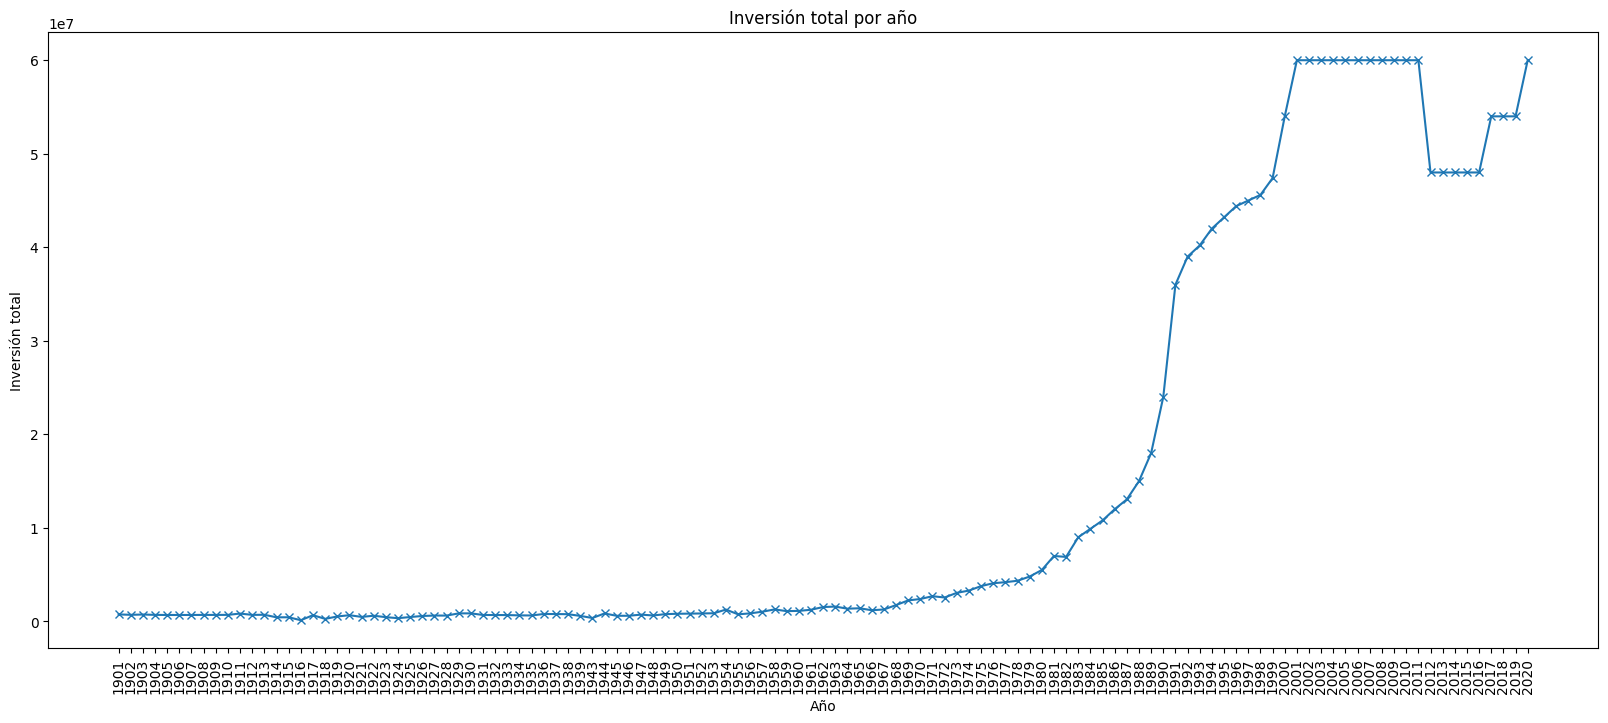

In [11]:
import matplotlib.pyplot as plt

# Agrupar los datos por año y calcular la suma de prize_amount_real
inversion_total_por_año = silver.groupby('year')['prize_amount_real'].sum()

# Generar la gráfica de línea
plt.figure(figsize=(20, 8))
plt.plot(inversion_total_por_año.index, inversion_total_por_año.values, marker="x")
plt.xticks(rotation='vertical')
plt.xlabel('Año')
plt.ylabel('Inversión total')
plt.title('Inversión total por año')
plt.show()

Podemos observar que año a año la inversión ha ido aumentando. Aunque parece que desde el año 2000 se ha mantenido y no se ha invertido más.

In [12]:
"¿Hay algún laureado que haya recibido más de dos premios? Muestra el top 5."

# Contar el número de premios recibidos por cada laureado
premios_por_laureado = silver['full_name'].value_counts()

# Filtrar los laureados que han recibido más de dos premios
laureados_con_mas_de_dos_premios = premios_por_laureado[premios_por_laureado > 2]

# Obtener el top 5 de laureados con más premios
top_5_laureados = laureados_con_mas_de_dos_premios.head(5)

top_5_laureados

John Bardeen                   4
Marie Curie, née Sklodowska    4
Frederick Sanger               4
Linus Carl Pauling             4
Name: full_name, dtype: int64

In [13]:
"¿Qué categoría es la que más premios ha recibido? ¿Y que más dinero ha entregado?"

# Calcular el número de premios por categoría
premios_por_categoria = silver['category_full_name'].value_counts()

# Calcular la suma de prize_amount_real por categoría
dinero_por_categoria = silver.groupby('category_full_name')['prize_amount_real'].sum()

# Obtener la categoría con más premios
categoria_mas_premios = premios_por_categoria.idxmax()

# Obtener la categoría que ha entregado más dinero
categoria_mas_dinero = dinero_por_categoria.idxmax()

print("La categoría que más premios ha recibido es:", categoria_mas_premios)
print("")
print("La categoría que más dinero ha entregado es:", categoria_mas_dinero)

La categoría que más premios ha recibido es: The Nobel Prize in Physiology or Medicine

La categoría que más dinero ha entregado es: The Nobel Prize in Chemistry
